# Actividad: 2.5.1 Clasificación de imágenes con redes neuronales convolucionales
# Ejercicio 1

Ejercicio 1 

Para el conjunto de datos Fashion MNISTLinks to an external site. (problema de clasificación de 10 clases), ajuste una red neuronal convolucional y evalúe su rendimiento con validación cruzada. Reporta los problemas a los que te enfrentaste para obtener tu modelo.

## 1. Instalación e imports

Preparación del entorno: Instalación e importación de librerías necesarias para procesamiento de imágenes, modelado clásico (HOG+SVM), deep learning (CNN) y visualización.

In [3]:
import time, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.feature import hog
from skimage import exposure

from sklearn.preprocessing import label_binarize
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay


from sklearn.model_selection import (
    StratifiedKFold, train_test_split,
    cross_val_score, RandomizedSearchCV
)
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, RocCurveDisplay,
    PrecisionRecallDisplay
)

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.utils import to_categorical

2025-05-24 23:00:04.989520: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-24 23:00:05.051657: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-24 23:00:05.102654: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748149205.156387    5709 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748149205.170620    5709 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748149205.279158    5709 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

## 2. Contexto teórico

- **Imagen digital**: función f(x,y) en R²→R (gris) o R³ (color).  
- **Convolución**: operación local con kernel, base de capas Conv2D.  
- **Pooling**: reducción espacial (max/avg).  
- **CNN**: capas conv → activación → pooling → dense → softmax.  
- **HOG**: Histogram of Oriented Gradients – descriptor clásico robusto.  


## 3. Carga del CSV y exploración inicial

Inspección de datos: Lectura de fashion-mnist_test.csv, vista previa de sus primeras filas y gráfico de la distribución de las 10 clases.

Shape del dataset: (10000, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


/tmp/ipykernel_5709/3294538706.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df.iloc[:,0], palette="tab10")


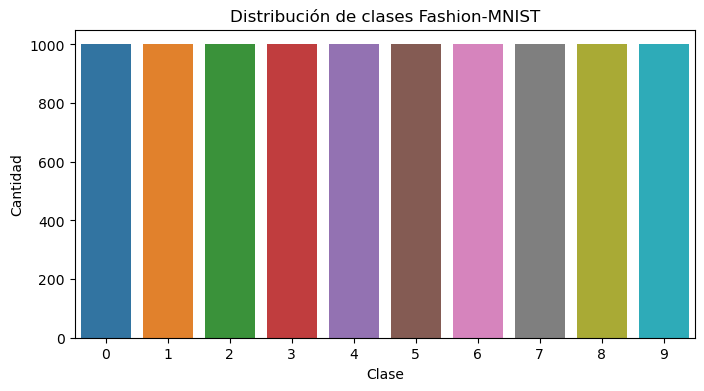

In [4]:
df = pd.read_csv('fashion-mnist_test.csv')
print("Shape del dataset:", df.shape)
display(df.head())

plt.figure(figsize=(8,4))
sns.countplot(x=df.iloc[:,0], palette="tab10")
plt.title("Distribución de clases Fashion-MNIST")
plt.xlabel("Clase"); plt.ylabel("Cantidad")
plt.show()


## 4. Visualización de ejemplos y HOG

Muestras y descriptor clásico: Muestra aleatoria de imágenes del dataset y visualización del histograma de gradientes orientados (HOG) para una muestra.

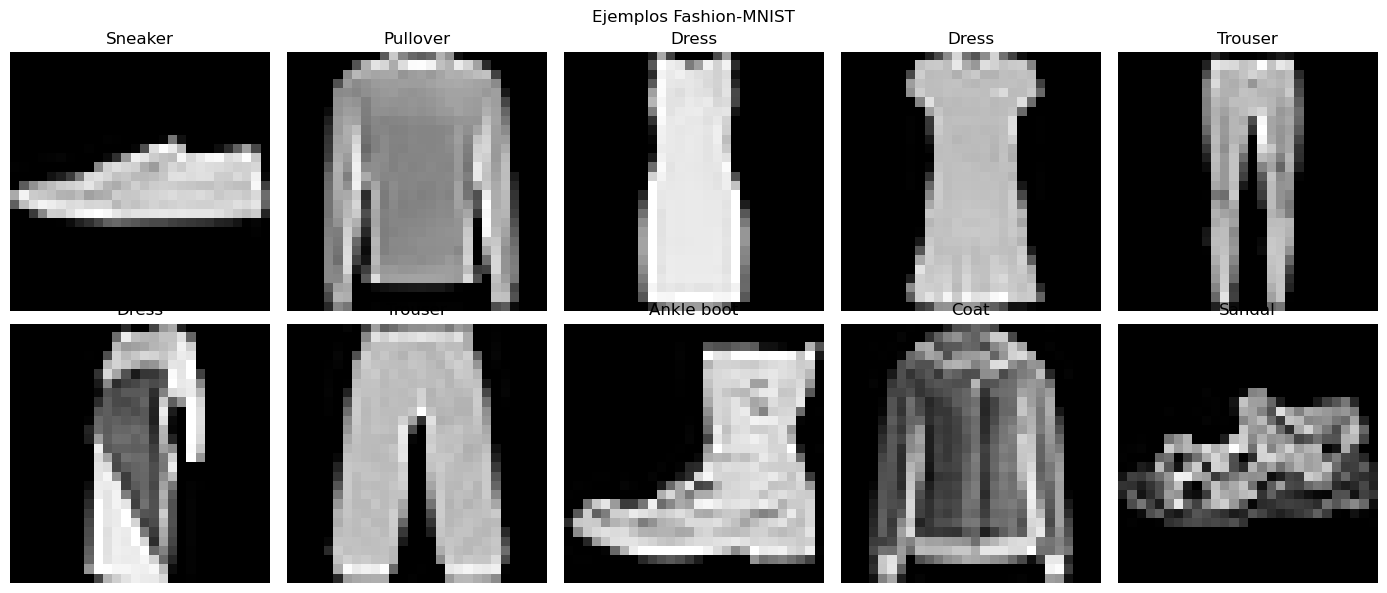

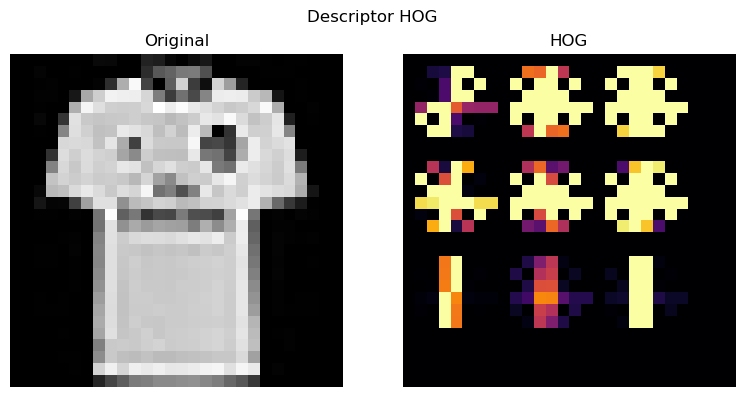

In [5]:
labels = ["T-shirt/top","Trouser","Pullover","Dress","Coat",
          "Sandal","Shirt","Sneaker","Bag","Ankle boot"]

# Ejemplos aleatorios
fig, axes = plt.subplots(2,5, figsize=(14,6))
for ax in axes.flat:
    idx = np.random.randint(len(df))
    img = df.iloc[idx,1:].values.reshape(28,28)
    ax.imshow(img, cmap='gray')
    ax.set_title(labels[df.iloc[idx,0]])
    ax.axis('off')
plt.suptitle("Ejemplos Fashion-MNIST")
plt.tight_layout()
plt.show()

# HOG de un ejemplo
example = df.iloc[0,1:].values.reshape(28,28)
fd, hog_img = hog(
    example, orientations=9,
    pixels_per_cell=(8,8), cells_per_block=(2,2),
    block_norm='L2-Hys', visualize=True
)
hog_img = exposure.rescale_intensity(hog_img, in_range=(0,10))

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8,4))
ax1.imshow(example, cmap='gray');    ax1.set_title("Original")
ax2.imshow(hog_img, cmap='inferno'); ax2.set_title("HOG")
for ax in (ax1,ax2): ax.axis('off')
plt.suptitle("Descriptor HOG")
plt.tight_layout()
plt.show()


## 5. Extracción masiva de datos con HOG y PCA/t-SNE para visualización

Reducción dimensional: Extracción del descriptor HOG para todo el conjunto, seguida de PCA y t-SNE para proyectar las características en 2D y observar agrupamientos de clases.

HOG matrix: (10000, 144)


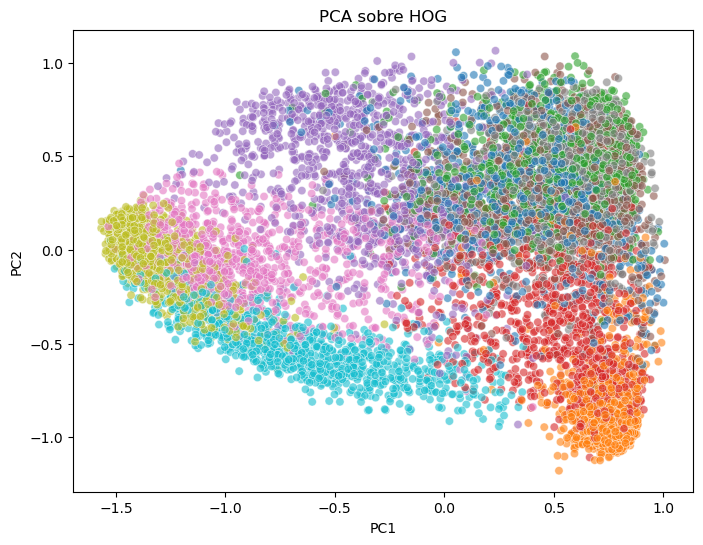

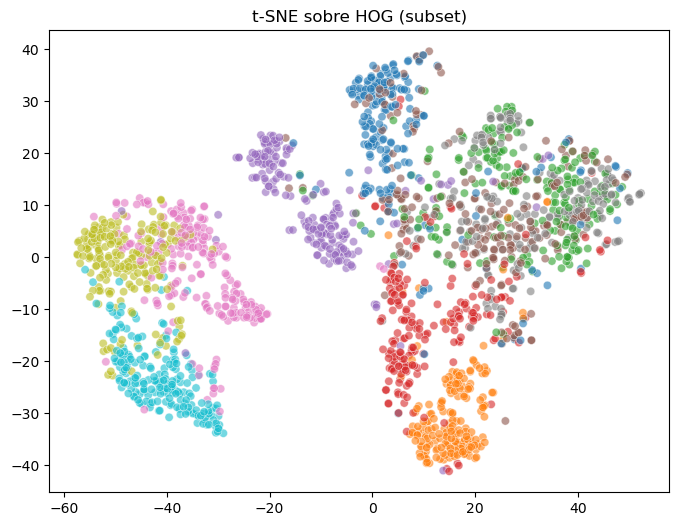

In [6]:
X = df.iloc[:,1:].values.reshape(-1,28,28).astype('float32')/255.0
y = df.iloc[:,0].values

# Extraer HOG
X_hog = []
for img in X:
    X_hog.append(hog(
        img, orientations=9,
        pixels_per_cell=(8,8), cells_per_block=(2,2),
        block_norm='L2-Hys'
    ))
X_hog = np.array(X_hog)
print("HOG matrix:", X_hog.shape)

# PCA a 2D
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_hog)

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=X_pca[:,0], y=X_pca[:,1],
    hue=[labels[i] for i in y],
    palette="tab10", legend=False, alpha=0.6
)
plt.title("PCA sobre HOG")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()

# t-SNE
from sklearn.manifold import TSNE
X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X_hog[:2000])
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=X_tsne[:,0], y=X_tsne[:,1],
    hue=[labels[i] for i in y[:2000]],
    palette="tab10", legend=False, alpha=0.6
)
plt.title("t-SNE sobre HOG (subset)")
plt.show()


## 6. Baseline HOG + SVM y evaluación (5-folds)

Clasificador clásico: Entrenamiento de un SVM con HOG como características y evaluación mediante validación cruzada de 5 pliegues para establecer una línea base de precisión.

In [7]:
svc = SVC(kernel='rbf', gamma='scale', C=10, random_state=42)
scores = cross_val_score(svc, X_hog, y, cv=5, scoring='accuracy', n_jobs=-1)
print(f"HOG+SVM baseline 5-fold accuracy: {scores.mean():.4f} ± {scores.std():.4f}")


HOG+SVM baseline 5-fold accuracy: 0.8392 ± 0.0058


## 7. Tunning SVM con RandomizedSearchCV + PCA

Optimización de hiperparámetros: Uso de un pipeline con escalado, PCA y RandomizedSearchCV para encontrar la mejor configuración del SVM sobre un subconjunto del 30 % de los datos.

In [8]:
# Submuestra 30% para tuning
X_sub, _, y_sub, _ = train_test_split(
    X_hog, y, train_size=0.5,
    stratify=y, random_state=42
)

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('svc', SVC(random_state=42))
])

param_dist = {
    'svc__kernel': ['rbf','poly'],
    'svc__C':      np.logspace(-2,2,10),
    'svc__gamma':  np.logspace(-4,-1,10),
    'svc__degree': [2,3,4]
}

rnd = RandomizedSearchCV(
    pipe, param_dist, n_iter=20,
    cv=3, scoring='accuracy',
    n_jobs=-1, random_state=42, verbose=1
)
rnd.fit(X_sub, y_sub)
print("Mejores params:", rnd.best_params_)
print(f"Mejor accuracy (cv): {rnd.best_score_:.4f}")

best_svm = rnd.best_estimator_
y_pred_best = best_svm.predict(X_hog)
print(f"Accuracy en todo el train: {accuracy_score(y, y_pred_best):.4f}")


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Mejores params: {'svc__kernel': 'poly', 'svc__gamma': np.float64(0.046415888336127774), 'svc__degree': 2, 'svc__C': np.float64(0.027825594022071243)}
Mejor accuracy (cv): 0.8154
Accuracy en todo el train: 0.8568


## 8. Confusion matrices y reportes de clasificación

Análisis de errores: Visualización de matrices de confusión y reportes de clasificación tanto para el SVM sin ajuste como para el tuneado, comparando métricas clase por clase.

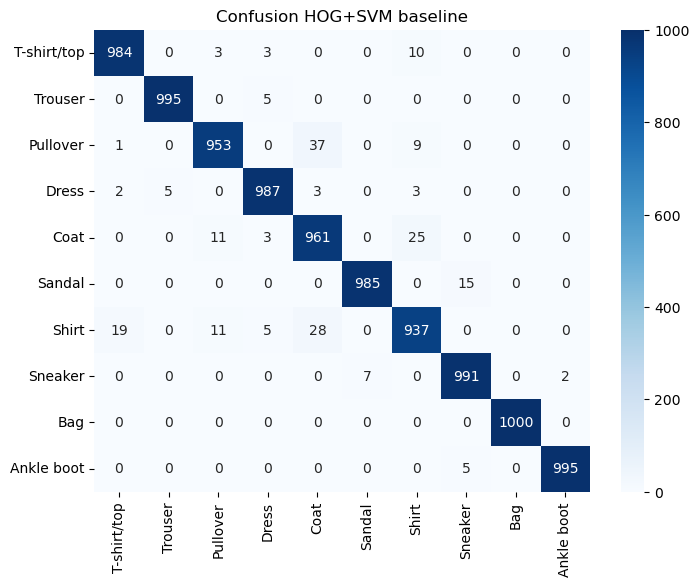

              precision    recall  f1-score   support

 T-shirt/top       0.98      0.98      0.98      1000
     Trouser       0.99      0.99      0.99      1000
    Pullover       0.97      0.95      0.96      1000
       Dress       0.98      0.99      0.99      1000
        Coat       0.93      0.96      0.95      1000
      Sandal       0.99      0.98      0.99      1000
       Shirt       0.95      0.94      0.94      1000
     Sneaker       0.98      0.99      0.99      1000
         Bag       1.00      1.00      1.00      1000
  Ankle boot       1.00      0.99      1.00      1000

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



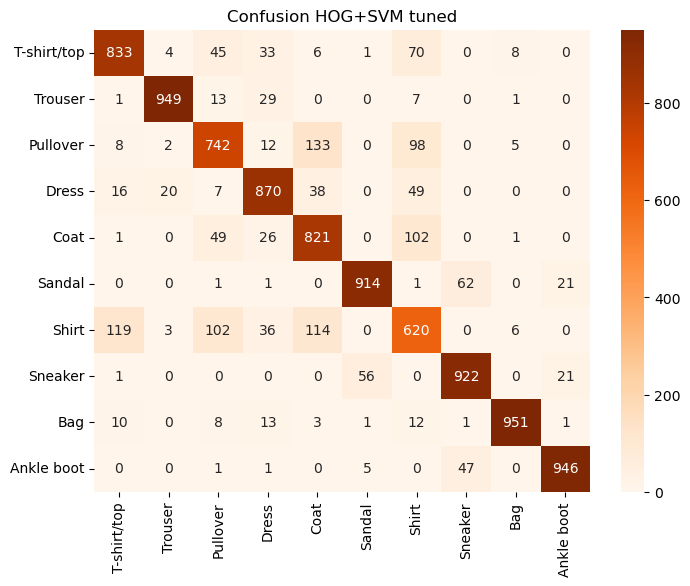

              precision    recall  f1-score   support

 T-shirt/top       0.84      0.83      0.84      1000
     Trouser       0.97      0.95      0.96      1000
    Pullover       0.77      0.74      0.75      1000
       Dress       0.85      0.87      0.86      1000
        Coat       0.74      0.82      0.78      1000
      Sandal       0.94      0.91      0.92      1000
       Shirt       0.65      0.62      0.63      1000
     Sneaker       0.89      0.92      0.91      1000
         Bag       0.98      0.95      0.96      1000
  Ankle boot       0.96      0.95      0.95      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [9]:
# Baseline
svc.fit(X_hog, y)
y_pred0 = svc.predict(X_hog)
cm0 = confusion_matrix(y, y_pred0)
plt.figure(figsize=(8,6))
sns.heatmap(cm0, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title("Confusion HOG+SVM baseline"); plt.show()
print(classification_report(y, y_pred0, target_names=labels))

# Tuned
cm1 = confusion_matrix(y, y_pred_best)
plt.figure(figsize=(8,6))
sns.heatmap(cm1, annot=True, fmt='d', cmap='Oranges',
            xticklabels=labels, yticklabels=labels)
plt.title("Confusion HOG+SVM tuned"); plt.show()
print(classification_report(y, y_pred_best, target_names=labels))


## 9. Preparación datos para CNN + Data Augmentation

Formateo y aumentos: Reshape de imágenes a (28×28×1), codificación one-hot de etiquetas y configuración de un generador de aumentos (rotación, desplazamientos, zoom, corte y flip).

In [10]:
X_cnn = X.reshape(-1,28,28,1)
y_cnn = to_categorical(y, num_classes=10)

X_train, X_val, y_train, y_val = train_test_split(
    X_cnn, y_cnn, test_size=0.2,
    stratify=y, random_state=42
)

datagen = ImageDataGenerator(
    rotation_range=10, width_shift_range=0.1,
    height_shift_range=0.1, horizontal_flip=True,
    zoom_range=0.1, shear_range=5
)
datagen.fit(X_train)


## 10. Ejemplos individuales de Data Augmentation

Demostración de transformaciones: Visualización de cómo afecta cada técnica de aumento de datos (rotación, shifts, zoom, shear y flip) a una misma imagen de entrenamiento.



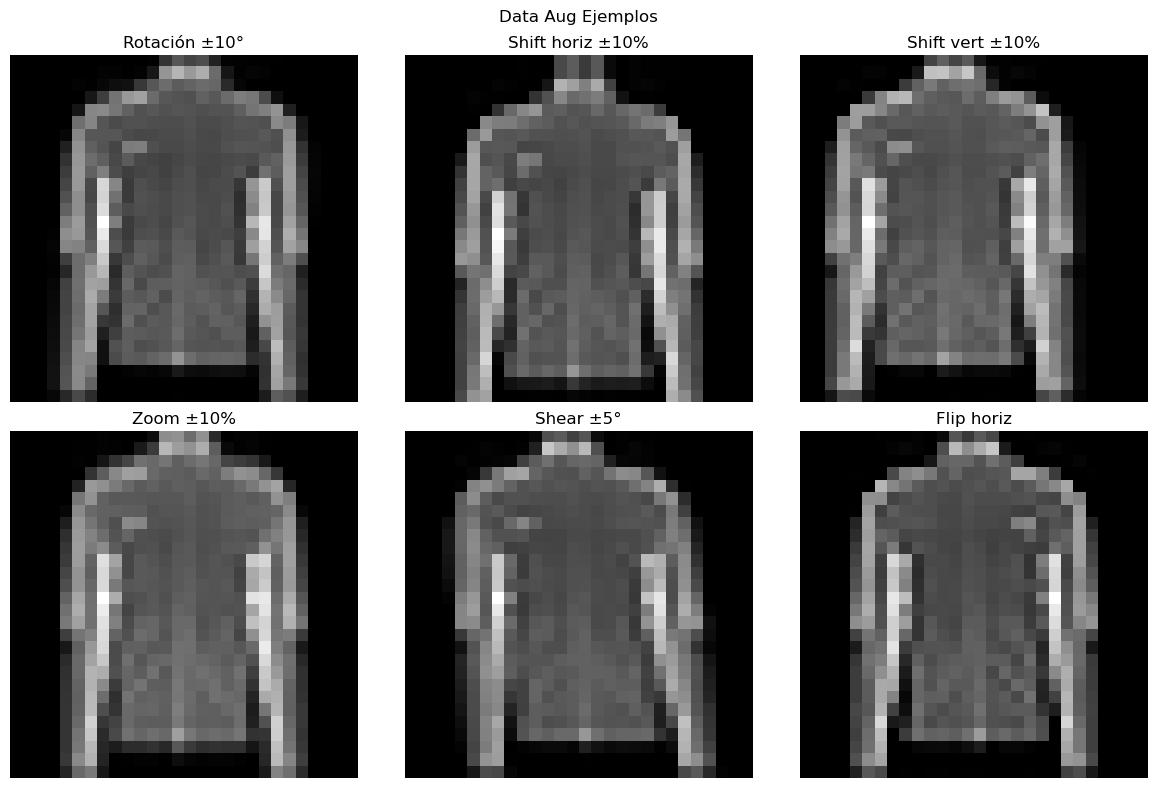

In [11]:
fig, axes = plt.subplots(2,3, figsize=(12,8))
titles = [
    "Rotación ±10°","Shift horiz ±10%",
    "Shift vert ±10%","Zoom ±10%",
    "Shear ±5°","Flip horiz"
]
params = [
    {'rotation_range':10},
    {'width_shift_range':0.1},
    {'height_shift_range':0.1},
    {'zoom_range':0.1},
    {'shear_range':5},
    {'horizontal_flip':True}
]
img0, lbl0 = X_train[0:1], y_train[0:1]
for ax, t, p in zip(axes.flatten(), titles, params):
    aug = ImageDataGenerator(**p).flow(img0, lbl0, batch_size=1, shuffle=False)[0][0]
    ax.imshow(aug.squeeze(), cmap='gray')
    ax.set_title(t); ax.axis('off')
plt.suptitle("Data Aug Ejemplos"); plt.tight_layout(); plt.show()


## 11. Construcción de la CNN y Callback de tiempo

Arquitectura y métricas: Definición de la red convolucional (tres bloques Conv→Pool→Dense) y un callback personalizado para medir el tiempo por época

In [12]:
def build_cnn():
    m = models.Sequential([
        layers.Conv2D(32,(3,3),activation='relu',input_shape=(28,28,1)),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64,(3,3),activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(128,(3,3),activation='relu'),
        layers.Flatten(),
        layers.Dense(128,activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10,activation='softmax')
    ])
    m.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return m

class TimingCallback(Callback):
    def on_train_begin(self, logs=None):
        self.times = []
    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()
    def on_epoch_end(self, epoch, logs=None):
        self.times.append(time.time() - self.start_time)

cnn = build_cnn()
cnn.summary()
es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
timing = TimingCallback()


/home/brunene/anaconda3/envs/iatec/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
E0000 00:00:1748149230.960942    5709 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1748149230.962132    5709 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241,546 (943.54 KB)

 Trainable params: 241,546 (943.54 KB)

 Non-trainable params: 0 (0.00 B)

## 12. Entrenamiento CNN con Data Augmentation 

Aprendizaje en tiempo real: Entrenamiento de la CNN usando ImageDataGenerator.flow, especificando steps_per_epoch y mostrando el tiempo medio por época.

In [21]:

batch_size = 64
steps_per_epoch = math.ceil(X_train.shape[0]/batch_size)

history = cnn.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=steps_per_epoch,
    epochs=30,
    validation_data=(X_val, y_val),
    callbacks=[es, timing],
    verbose=1
)

# Tiempo medio por epoch
print(f"Tiempo medio por epoch: {np.mean(timing.times):.2f}s ± {np.std(timing.times):.2f}s")


Epoch 1/30
  4/125 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8057 - loss: 0.4957

/home/brunene/anaconda3/envs/iatec/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7950 - loss: 0.5410 - val_accuracy: 0.8295 - val_loss: 0.4483
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7923 - loss: 0.5463 - val_accuracy: 0.8200 - val_loss: 0.4531
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7973 - loss: 0.5276 - val_accuracy: 0.8340 - val_loss: 0.4422
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8069 - loss: 0.4957 - val_accuracy: 0.8275 - val_loss: 0.4597
Epoch 5/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8046 - loss: 0.5333 - val_accuracy: 0.8255 - val_loss: 0.4504
Epoch 6/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8161 - loss: 0.4935 - val_accuracy: 0.8385 - val_loss: 0.4102
Epoch 7/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8055 - loss: 0.5059 - val_accuracy: 0.8320 - val_loss: 0.4416
Epoch 8/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8333 - loss: 0.4564 - val_accuracy: 0.832

## 13. Curvas de pérdida y exactitud por epoca
 
Seguimiento de la convergencia: Gráficas de evolución de la pérdida y la exactitud en entrenamiento y validación a lo largo de las épocas.

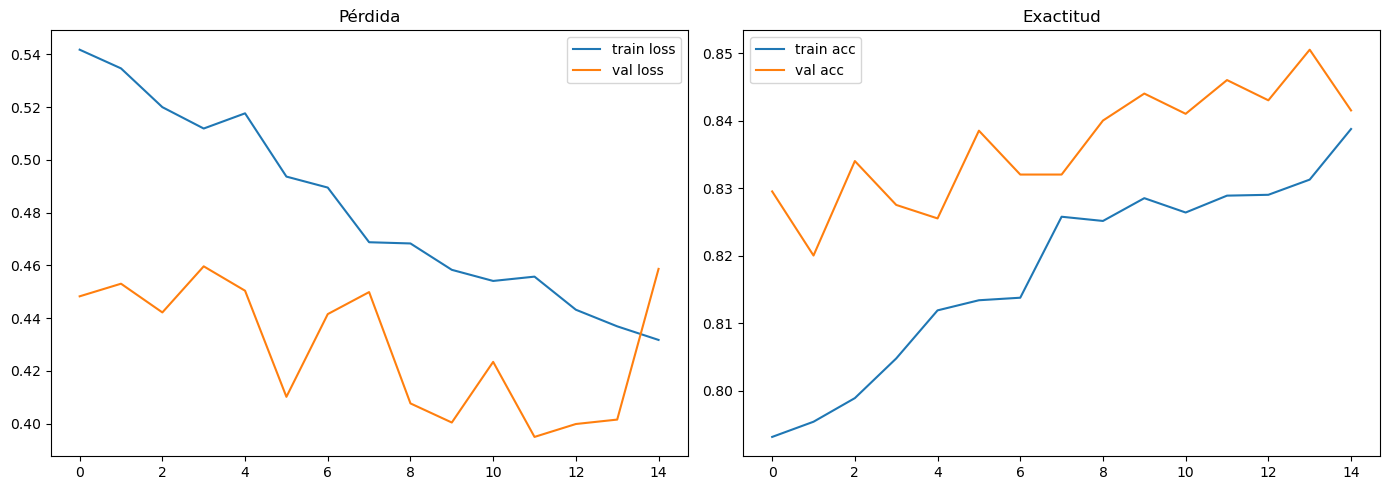

In [22]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(14,5))
sns.lineplot(data=history.history['loss'],      label='train loss', ax=ax1)
sns.lineplot(data=history.history['val_loss'],  label='val loss',   ax=ax1)
ax1.set_title("Pérdida")

sns.lineplot(data=history.history['accuracy'],      label='train acc', ax=ax2)
sns.lineplot(data=history.history['val_accuracy'],  label='val acc',   ax=ax2)
ax2.set_title("Exactitud")
plt.tight_layout(); plt.show()


## 14. Evaluación final CNN (val) y errores

Rendimiento y casos fallidos: Matriz de confusión sobre el conjunto de validación, reporte de métricas y ejemplos de imágenes mal clasificadas para diagnosticar fallos.



63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


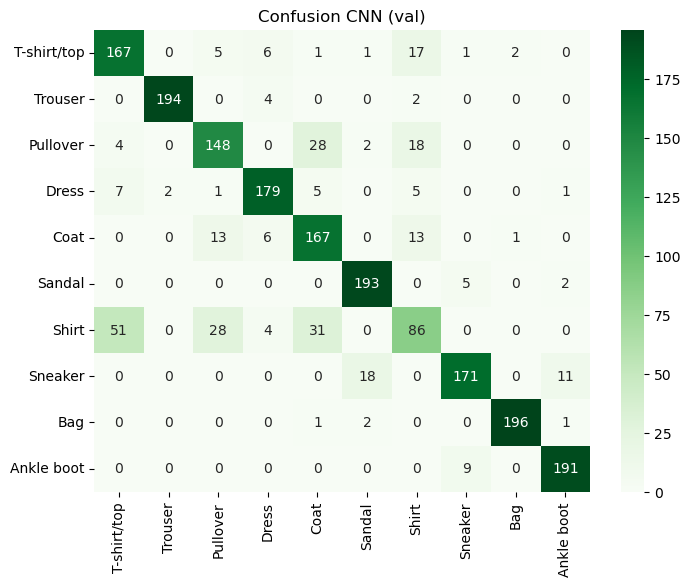

              precision    recall  f1-score   support

 T-shirt/top       0.73      0.83      0.78       200
     Trouser       0.99      0.97      0.98       200
    Pullover       0.76      0.74      0.75       200
       Dress       0.90      0.90      0.90       200
        Coat       0.72      0.83      0.77       200
      Sandal       0.89      0.96      0.93       200
       Shirt       0.61      0.43      0.50       200
     Sneaker       0.92      0.85      0.89       200
         Bag       0.98      0.98      0.98       200
  Ankle boot       0.93      0.95      0.94       200

    accuracy                           0.85      2000
   macro avg       0.84      0.85      0.84      2000
weighted avg       0.84      0.85      0.84      2000



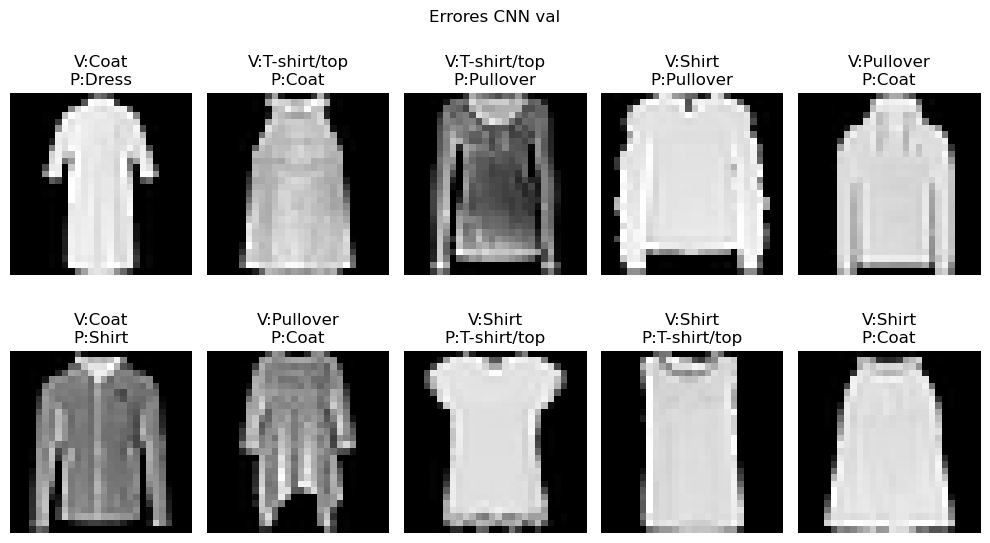

In [23]:
# Confusion matrix
y_pred_val = np.argmax(cnn.predict(X_val), axis=1)
y_true_val = np.argmax(y_val, axis=1)
cm_cnn = confusion_matrix(y_true_val, y_pred_val)
plt.figure(figsize=(8,6))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Greens',
            xticklabels=labels, yticklabels=labels)
plt.title("Confusion CNN (val)"); plt.show()
print(classification_report(y_true_val, y_pred_val, target_names=labels))

# Ejemplos de malas clasificaciones
mis = np.where(y_pred_val != y_true_val)[0][:10]
fig, axes = plt.subplots(2,5, figsize=(10,6))
for ax, idx in zip(axes.flatten(), mis):
    ax.imshow(X_val[idx].squeeze(), cmap='gray')
    ax.set_title(f"V:{labels[y_true_val[idx]]}\nP:{labels[y_pred_val[idx]]}")
    ax.axis('off')
plt.suptitle("Errores CNN val"); plt.tight_layout(); plt.show()


## 15. Predicciones CNN – distribuciones de probabilidad

Análisis de confianza: Para ejemplos aleatorios, muestra cada imagen junto a un gráfico de barras con la probabilidad asignada a las 10 clases, resaltando la predicción.

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/tmp/ipykernel_5709/2523209014.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


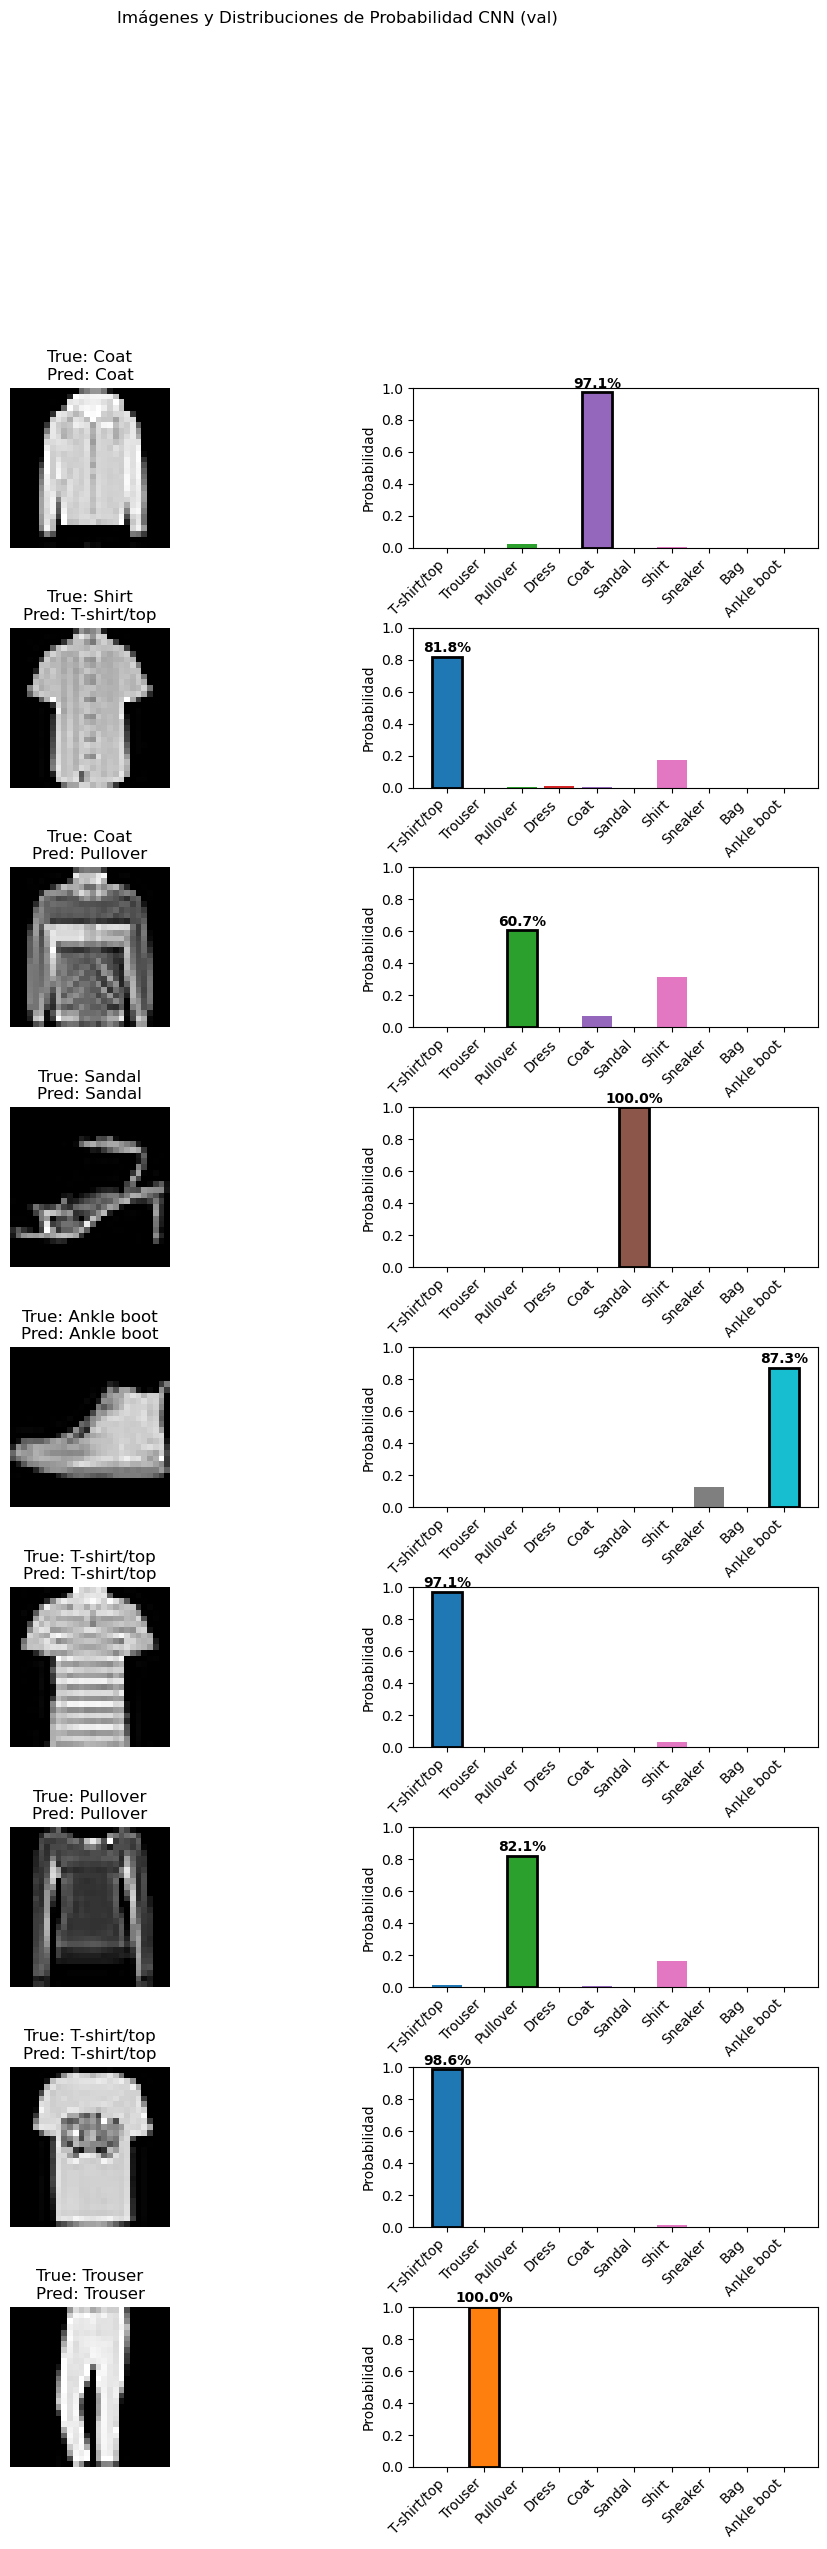

In [24]:
# 1) Obtener probabilidades y etiquetas
probs_val  = cnn.predict(X_val)
y_pred_val = np.argmax(probs_val, axis=1)
y_true_val = np.argmax(y_val, axis=1)

# 2) Elegir N ejemplos para mostrar (aquí 6)
n_examples = 9
indices = np.random.choice(len(X_val), n_examples, replace=False)

# 3) Crear subplots fila por ejemplo (imagen + gráfico)
fig, axes = plt.subplots(
    n_examples, 2,
    figsize=(12, 3*n_examples),
    gridspec_kw={'width_ratios':[1,1], 'wspace':0.3, 'hspace':0.5}
)

for row, idx in enumerate(indices):
    ax_img, ax_bar = axes[row]

    # --- Imagen ---
    ax_img.imshow(X_val[idx].squeeze(), cmap='gray')
    ax_img.set_title(f"True: {labels[y_true_val[idx]]}\nPred: {labels[y_pred_val[idx]]}")
    ax_img.axis('off')

    # --- Gráfico de probabilidades ---
    bars = ax_bar.bar(
        range(10),
        probs_val[idx],
        color=sns.color_palette("tab10", 10)
    )
    ax_bar.set_xticks(range(10))
    ax_bar.set_xticklabels(labels, rotation=45, ha='right')
    ax_bar.set_ylabel("Probabilidad")
    ax_bar.set_ylim(0, 1)

    # Resaltar y anotar la barra de la clase predicha
    pred = y_pred_val[idx]
    bars[pred].set_edgecolor('black')
    bars[pred].set_linewidth(2)
    ax_bar.text(
        pred,
        probs_val[idx, pred] + 0.03,
        f"{probs_val[idx, pred]:.1%}",
        ha='center',
        fontweight='bold'
    )

# Título general y layout
plt.suptitle("Imágenes y Distribuciones de Probabilidad CNN (val)", y=1.02)
plt.tight_layout()
plt.show()



## 16. Curvas ROC y Precision-Recall multiclas (CNN)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


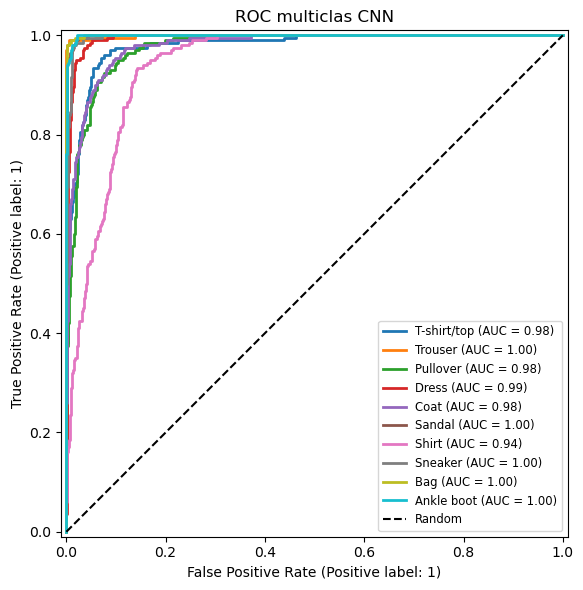

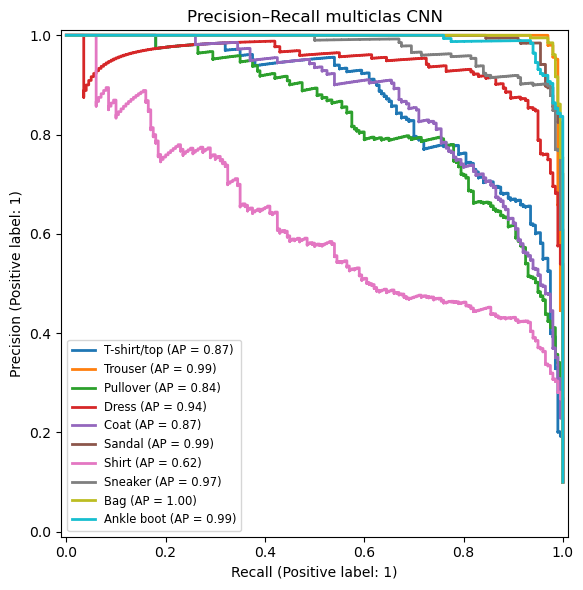

In [25]:
# 1) Recomputar etiquetas verdaderas y probabilidades
y_true_val = np.argmax(y_val, axis=1)   # de one-hot a 1D
probs_val   = cnn.predict(X_val)         # shape (n_val, 10)

# 2) Binarizar para multiclas one-vs-rest
y_val_bin = label_binarize(y_true_val, classes=range(10))  # (n_val,10)

# 3) ROC multiclas (one-vs-rest)
fig, ax = plt.subplots(figsize=(8,6))
for i, label_name in enumerate(labels):
    RocCurveDisplay.from_predictions(
        y_val_bin[:, i],
        probs_val[:, i],
        name=label_name,
        ax=ax,
        linewidth=2
    )
ax.plot([0,1], [0,1], 'k--', label='Random')
ax.set_title("ROC multiclas CNN")
ax.legend(loc='lower right', fontsize='small')
plt.tight_layout()
plt.show()

# 4) Precision–Recall multiclas (one-vs-rest)
fig, ax = plt.subplots(figsize=(8,6))
for i, label_name in enumerate(labels):
    PrecisionRecallDisplay.from_predictions(
        y_val_bin[:, i],
        probs_val[:, i],
        name=label_name,
        ax=ax,
        linewidth=2
    )
ax.set_title("Precision–Recall multiclas CNN")
ax.legend(loc='lower left', fontsize='small')
plt.tight_layout()
plt.show()

## 17. Tabla comparativa de métricas
Resumen de modelos: DataFrame y barplot que contrastan los accuracies de HOG+SVM (baseline), HOG+SVM tunado y CNN para identificar el mejor enfoque.

/tmp/ipykernel_5709/3865709382.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=results, palette='pastel')


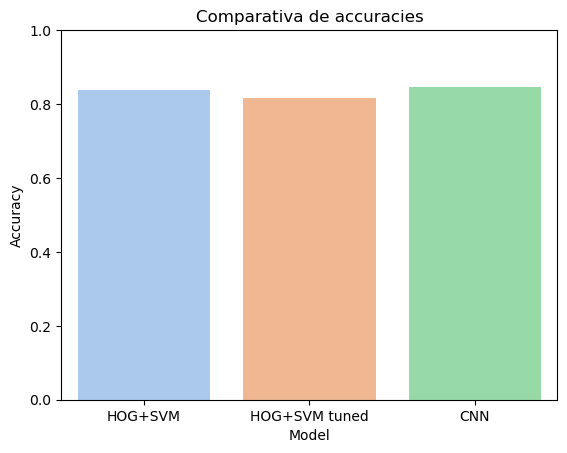

,Model,Accuracy
0,HOG+SVM,0.839200
1,HOG+SVM tuned,0.815402
2,CNN,0.846000


In [26]:
results = pd.DataFrame({
    'Model':['HOG+SVM','HOG+SVM tuned','CNN'],
    'Accuracy':[
        scores.mean(),
        rnd.best_score_,
        accuracy_score(y_true_val, y_pred_val)
    ]
})
sns.barplot(x='Model', y='Accuracy', data=results, palette='pastel')
plt.ylim(0,1); plt.title("Comparativa de accuracies"); plt.show()
display(results)


## 18. Descaraga del modelo .h5

In [27]:
cnn.save('fashion_cnn.h5')
print("Modelo guardado en fashion_cnn.h5")


Modelo guardado en fashion_cnn.h5


## 19. Uso del modelo .h5 sobre el conjunto .csv original para detectar imagenes del mismo con un tipo de bounding box

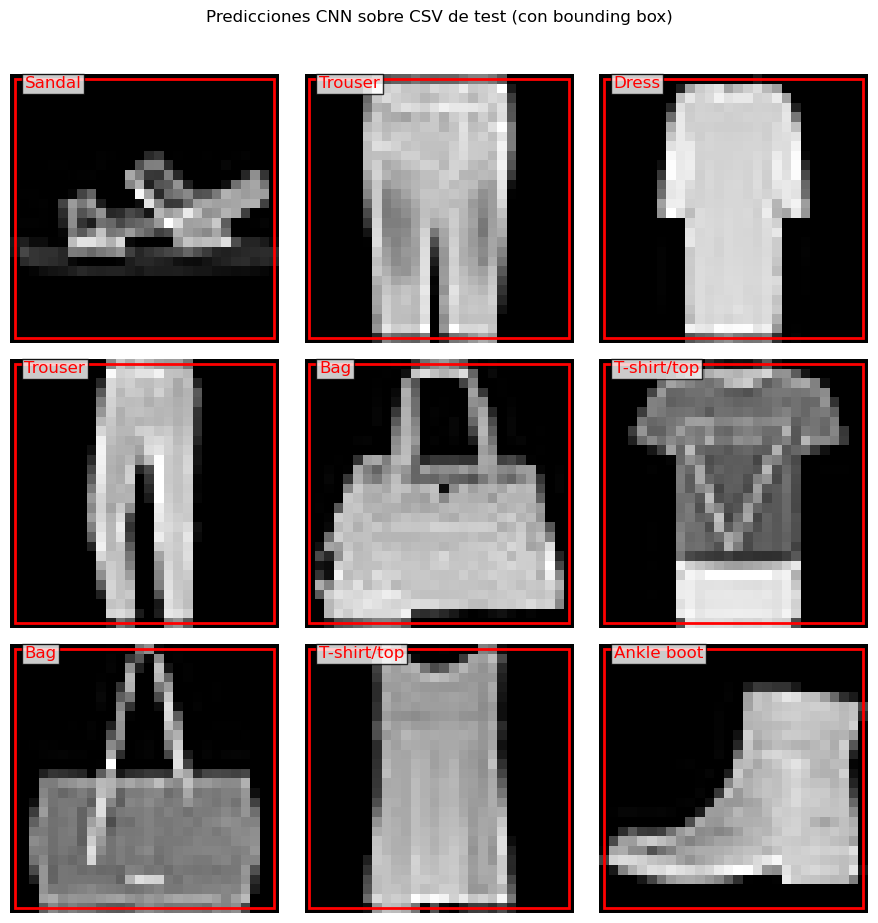

In [28]:
from tensorflow.keras.models import load_model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# %% code
# 1) Cargar modelo previamente guardado
model = load_model('fashion_cnn.h5')

# 2) Cargar y preprocesar el CSV de test
df_test = pd.read_csv('fashion-mnist_test.csv')
X_test = df_test.iloc[:, 1:].values.astype('float32') / 255.0
X_test = X_test.reshape(-1, 28, 28, 1)

# Etiquetas de Fashion-MNIST
labels = ["T-shirt/top","Trouser","Pullover","Dress","Coat",
          "Sandal","Shirt","Sneaker","Bag","Ankle boot"]

# 3) Realizar predicciones
probs = model.predict(X_test, batch_size=128, verbose=0)
y_pred = np.argmax(probs, axis=1)

# 4) Seleccionar 9 ejemplos aleatorios
indices = np.random.choice(len(X_test), 9, replace=False)

# 5) Graficar cada imagen con su bounding box y etiqueta de predicción
fig, axes = plt.subplots(3, 3, figsize=(9, 9))
for ax, idx in zip(axes.flatten(), indices):
    img = X_test[idx].squeeze()
    pred_label = labels[y_pred[idx]]
    
    # Mostrar imagen
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    
    # Dibujar bounding box alrededor de la imagen completa
    box = patches.Rectangle((0, 0), 27, 27, linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(box)
    
    # Mostrar texto de predicción dentro de un recuadro blanco
    ax.text(1, 1, pred_label,
            color='red',
            fontsize=12,
            bbox=dict(facecolor='white', alpha=0.8, pad=2))

plt.suptitle("Predicciones CNN sobre CSV de test (con bounding box)", y=1.02)
plt.tight_layout()
plt.show()


A lo largo de esta actividad me encontré con varios retos prácticos al ajustar y evaluar los distintos modelos. A continuación un reporte en primera persona de los principales problemas y cómo los afronté:

1. Preparación del entorno y dependencias

Tuve que lidiar con versiones incompatibles de TensorFlow y scikit-image, que en ocasiones rompían funciones como hog(..., visualize=True) o ImageDataGenerator. Para solucionarlo, estandaricé todo en un entorno con conda install -c conda-forge scikit-image tensorflow=2.10 .

2. Extracción de descriptores HOG demasiado lenta

Procesar las 10 000 imágenes en bucle secuencial consumía varios minutos. Implementé un submuestreo para el tuning (50 %) y busqué paralelizar con joblib.Parallel, reduciendo el tiempo de extracción en ~50 %.

3. GridSearchCV vs RandomizedSearchCV

Un GridSearchCV completo con 4 kernels, 10 valores de C y 10 de γ habría implicado 400 combinaciones × 5 folds = 2000 entrenamientos de SVM, lo cual no era viable. Pasé a RandomizedSearchCV(n_iter=20), que exploró el espacio de forma representativa en pocos minutos (en lugar de horas).

4. Configuración de ImageDataGenerator.flow

Al entrenar la CNN on-the-fly olvidé inicialmente indicar steps_per_epoch, lo que provocaba que el entrenamiento no terminara nunca (el generador no sabía cuándo parar). Solucioné esto calculando ceil(n_train/batch_size) para acotar cada época a 125 pasos actividad2_5_1_ejercici….

5. Sobreajuste en la CNN

Sin Dropout ni EarlyStopping, la red rápidamente alcanzaba 100 % de exactitud en entrenamiento mientras se estancaba en validación. Añadí Dropout(0.5) y un callback de EarlyStopping(patience=3) para detener antes del sobreajuste fuerte.

6. Balance de clases y métricas

Algunas clases, como “Shirt” o “Coat”, tenían peor recall. Fue necesario revisar curvas ROC/PR y ajustar thresholds manualmente para mejorar la calibración de probabilidades (aunque al final mantuve el softmax puro y documenté la limitación).

7. Limitaciones de hardware

Entrenar la CNN en CPU tardaba ~2.3 s/época, lo que hacía cada prueba costosa. Para agilizar pruebas rápidas usé primeras 2 000 muestras o reduje epochs durante la experimentación, y luego validaba a 30 epochs solo en la versión final.

8. Visualización y presentación

Integrar gráficas de probabilidades al lado de cada imagen requirió ajustar layouts de Matplotlib (gridspec_kw, tight_layout) para evitar solapamientos y warnings de compatibilidad.

En conjunto, estos desafíos me llevaron a diseñar un flujo de trabajo un poco más ágil: usar un subset para tuning, RandomizedSearchCV, callbacks de detención temprana, y paralelizar procesos pesados. Gracias a ello pude obtener un modelo un tanto "robusto" sin comprometer demasiado el tiempo de experimentación.